# Разработка стратегии взаимодействия с клиентами на основе аналитических данных.


**Заказчик:** 
Сеть фитнес-центров «Культурист-датасаентист»

**Цель проекта:**
Изучить и спрогнозировать отток клиентов. 

**Задачи проекта:** 
<li> сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства  
<li> проанализировать основные признаки, наиболее сильно влияющие на отток;
<li> разработать рекомендации по повышению качества работы с клиентами 
       
**Описание данных:**
Данные содержат информацию на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля: 
    
<li> 'Churn' — факт оттока в текущем месяце (1 - отток, 0 - не было оттока);
<li> 'gender' — пол;
<li> 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
<li> 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
<li> Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
<li> 'Phone' — наличие контактного телефона;
<li> 'Age' — возраст;
<li> 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
<li> 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
<li> 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
<li> 'Group_visits' — факт посещения групповых занятий;
<li> 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
<li> 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
<li> 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [1]:
import pandas as pd
import numpy as np
import re
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = -1
import matplotlib.pyplot as plt
import scipy.stats as st
import datetime as dt
import plotly.express as px
import seaborn as sns
from plotly import graph_objects as go
import math as mth
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import warnings  
warnings.filterwarnings("ignore")  


## Подготовка данных 

In [2]:
path = '/datasets/'
data = pd.read_csv(path + 'gym_churn.csv') 

In [3]:
display(data.head())
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB



<li> Датасет заполнен полностью, всключает в себя 4000 строк.
<li> Датасет не имеет категориальных столцов, все столбцы имеют численный формат.
<li> Для удобства переименую столбцы (приведу к нижнему регистру)
<li> Проверю датасет на дубликаты
<li> Проверю столбцы на корректность данных

## Исследовательский анализ данных (EDA)

### Переименование столбцов

In [4]:
data = data.rename(columns={
    'Near_Location': 'near_location', 
    'Partner': 'partner', 
    'Promo_friends': 'promo_friends', 
    'Phone': 'phone', 
    'Contract_period': 'contract_period',
    'Group_visits': 'group_visits',
    'Age': 'age',
    'Avg_additional_charges_total': 'avg_additional_charges_total',
    'Month_to_end_contract': 'month_to_end_contract',
    'Lifetime': 'lifetime',
    'Avg_class_frequency_total': 'avg_class_frequency_total',
    'Avg_class_frequency_current_month': 'avg_class_frequency_current_month',
    'Churn': 'churn'})

### Обработка дубликатов

In [5]:
print('Дубликатов в датесете: ', data.duplicated().sum()) 

Дубликатов в датесете:  0


### Проверка значений столбцов

In [6]:
for col in data.columns:
    print('Уникальные значения столбца', col, ':', data[col].unique())

Уникальные значения столбца gender : [1 0]
Уникальные значения столбца near_location : [1 0]
Уникальные значения столбца partner : [1 0]
Уникальные значения столбца promo_friends : [1 0]
Уникальные значения столбца phone : [0 1]
Уникальные значения столбца contract_period : [ 6 12  1]
Уникальные значения столбца group_visits : [1 0]
Уникальные значения столбца age : [29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]
Уникальные значения столбца avg_additional_charges_total : [ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361]
Уникальные значения столбца month_to_end_contract : [ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]
Уникальные значения столбца lifetime : [ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]
Уникальные значения столбца avg_class_frequency_total : [0.02039795 1.92293606 1.85909835 ... 2.78614636 1.63010814 1.10183221]
Уникальные значения столбца avg_class_frequency_current_m


<li> Столбцы заполнены корректно, все бинарные признаки имеют значения только 0 и 1, затычек нет.
<li> Столбец month_to_end_contract заполнен целыми числами, но в инфо его тип float, изменю тип данного столбца.

In [7]:
data['month_to_end_contract'] = data['month_to_end_contract'].astype(int)

In [8]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000



В таких признаках как avg_additional_charges_total, lifetime, avg_class_frequency_total, avg_class_frequency_current_month могут присутсвовать выбросы.

### Обработка выбросов

#### Найду 95 перцентиль для столбцов

In [9]:
def percentile_95(data, col):
    print('95 перцентиль в столбце', col, ':',np.percentile(data[col], [95]))
    

In [10]:
percentile_95(data, 'avg_additional_charges_total')
percentile_95(data, 'lifetime')
percentile_95(data, 'avg_class_frequency_total')
percentile_95(data, 'avg_class_frequency_current_month')

95 перцентиль в столбце avg_additional_charges_total : [323.44087589]
95 перцентиль в столбце lifetime : [11.]
95 перцентиль в столбце avg_class_frequency_total : [3.53564837]
95 перцентиль в столбце avg_class_frequency_current_month : [3.54906154]


Отбросим выбросы и посмотрим насколько сократился датасет.

In [11]:
data_new = data.query(
    'avg_additional_charges_total <= 324 & lifetime <= 11 & avg_class_frequency_total <= 4 & avg_class_frequency_current_month <= 4').reset_index()

In [12]:
data_new.info()
data_new.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 15 columns):
index                                3547 non-null int64
gender                               3547 non-null int64
near_location                        3547 non-null int64
partner                              3547 non-null int64
promo_friends                        3547 non-null int64
phone                                3547 non-null int64
contract_period                      3547 non-null int64
group_visits                         3547 non-null int64
age                                  3547 non-null int64
avg_additional_charges_total         3547 non-null float64
month_to_end_contract                3547 non-null int64
lifetime                             3547 non-null int64
avg_class_frequency_total            3547 non-null float64
avg_class_frequency_current_month    3547 non-null float64
churn                                3547 non-null int64
dtypes: float64(3), int64(12)
me

,index,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,3547.000000,3547.000000,3547.000000,3547.000000,3547.00000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000
mean,2000.024246,0.510290,0.839583,0.483507,0.30561,0.904144,4.555681,0.403440,29.090499,134.076915,4.214829,3.094728,1.818888,1.692169,0.297153
std,1157.798810,0.499965,0.367044,0.499798,0.46073,0.294435,4.510368,0.490657,3.274521,82.417436,4.159208,2.684383,0.905713,0.992411,0.457069
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,985.500000,0.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.000000,27.000000,64.669028,1.000000,1.000000,1.165041,0.930272,0.000000
50%,1999.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.000000,29.000000,127.859156,1.000000,2.000000,1.794838,1.658196,0.000000
75%,3006.500000,1.000000,1.000000,1.000000,1.00000,1.000000,6.000000,1.000000,31.000000,196.627630,6.000000,5.000000,2.461356,2.428146,1.000000
max,3999.000000,1.000000,1.000000,1.000000,1.00000,1.000000,12.000000,1.000000,41.000000,323.533715,12.000000,11.000000,3.984524,3.968041,1.000000


После удаления выбросов, мы потеряли 11% данных. Что достаточно много. Рассмотрю 99 персентиль

#### Найду 99 перцентиль для столбцов

In [13]:
def percentile_99(data, col):
    print('99 перцентиль в столбце', col, ':',np.percentile(data[col], [99]))

In [14]:
percentile_99(data, 'avg_additional_charges_total')
percentile_99(data, 'lifetime')
percentile_99(data, 'avg_class_frequency_total')
percentile_99(data, 'avg_class_frequency_current_month')

99 перцентиль в столбце avg_additional_charges_total : [400.99612505]
99 перцентиль в столбце lifetime : [17.]
99 перцентиль в столбце avg_class_frequency_total : [4.19757925]
99 перцентиль в столбце avg_class_frequency_current_month : [4.18575779]


In [15]:
data_new_1 = data.query('avg_additional_charges_total <= 400 & lifetime < 17 & avg_class_frequency_total <= 4 & avg_class_frequency_current_month <= 4')

In [16]:
data_new_1.info()
data_new_1.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3830 entries, 0 to 3999
Data columns (total 14 columns):
gender                               3830 non-null int64
near_location                        3830 non-null int64
partner                              3830 non-null int64
promo_friends                        3830 non-null int64
phone                                3830 non-null int64
contract_period                      3830 non-null int64
group_visits                         3830 non-null int64
age                                  3830 non-null int64
avg_additional_charges_total         3830 non-null float64
month_to_end_contract                3830 non-null int64
lifetime                             3830 non-null int64
avg_class_frequency_total            3830 non-null float64
avg_class_frequency_current_month    3830 non-null float64
churn                                3830 non-null int64
dtypes: float64(3), int64(11)
memory usage: 448.8 KB


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000,3830.000000
mean,0.511749,0.843081,0.487728,0.309138,0.903133,4.648564,0.404961,29.152742,143.121337,4.296084,3.508616,1.828731,1.711320,0.276762
std,0.499927,0.363772,0.499915,0.462199,0.295815,4.548252,0.490949,3.266345,91.362808,4.195791,3.288799,0.912018,0.993922,0.447456
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,67.630122,1.000000,1.000000,1.168895,0.946555,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,134.112717,1.000000,3.000000,1.809321,1.686521,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,207.674948,6.000000,5.000000,2.480254,2.450450,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,398.395150,12.000000,16.000000,3.991598,3.968041,1.000000


Для дальнейшего исследоватния остаялю датасет data_new_1, в котором удалены выбросы согласно 99 перцентилю.


Портрет среднего пользователя фитнес-центра:
    
    1. пол не имеет значения
    
    2. Посетитель живет/работает рядом с фитнес-клубом
    
    3. Длительность абонемента от 1 месяц или 6 месяцев
    
    4. Возраст: 29 лет
    
    5. Посещает клуб 1 - 2 раза в неделю.

### Cредние значения признаков в группах: группа, ушедших в отток (1) и группа оставшихся (0).

In [17]:
data_churn = data_new_1.groupby('churn').agg('mean')

In [18]:
display(data_churn)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.512274,0.871841,0.538267,0.357040,0.903249,5.765704,0.457040,29.981588,153.962924,5.303610,4.473646,1.963928,1.966154
1,0.510377,0.767925,0.355660,0.183962,0.902830,1.729245,0.268868,26.986792,114.790019,1.663208,0.986792,1.475433,1.045386


<div style="border:solid blue 2px; padding: 20px">
<li> В обеих группах примерно одинаковое кол-во мужчин и женщин.
<li> В группе, которая ушла в отток, длительность контракта в среднем 2 месяца, а у тех, кто остался - 6 месяцев. Соответвенно, и разница в показателе "кол-во месяцев до окончания контракта" тоже значительно отличается.
<li> В группах нет разницы в возрасте и гендере.
<li> Группа, ушежшая в отток, принесла меньше суммарной выручки за другие услуги. 
<li> Ушедшие в отток в среднем посещали фитнес-клуб реже, чем те, кто остались (1 раз в неделю)

### Гистограммы распределения признаков для групп:  ушедших в отток (1) и оставшихся (0).

In [19]:
data_churn_0 = data_new_1.query('churn == 0')
data_churn_1 = data_new_1.query('churn == 1')

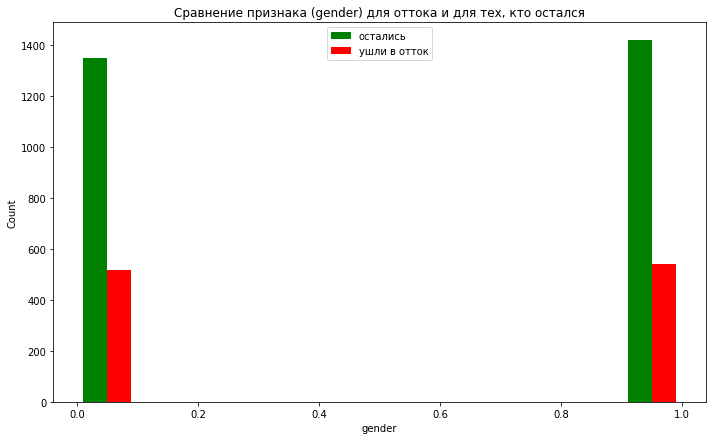

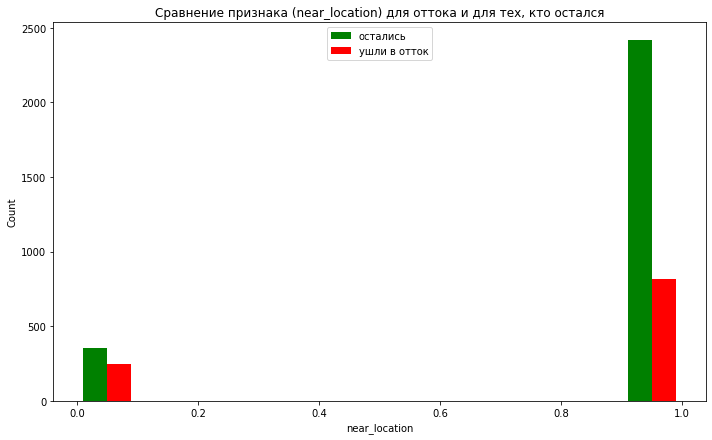

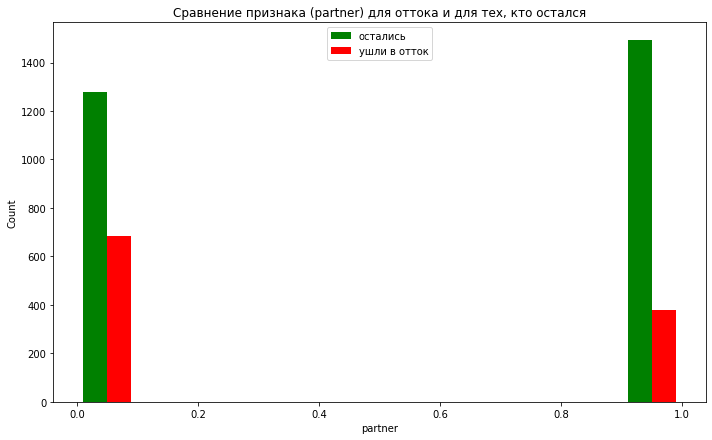

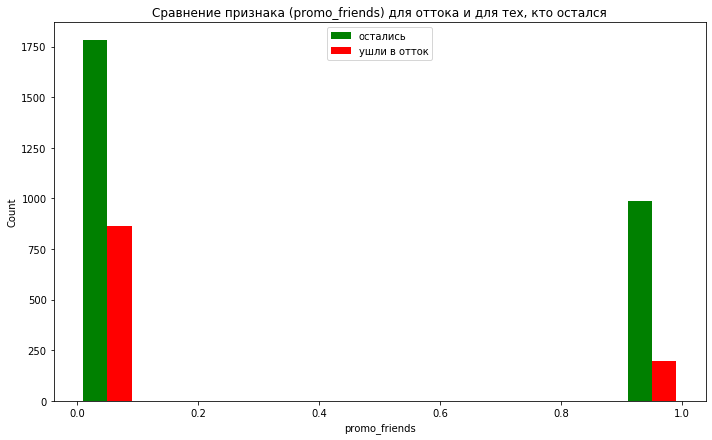

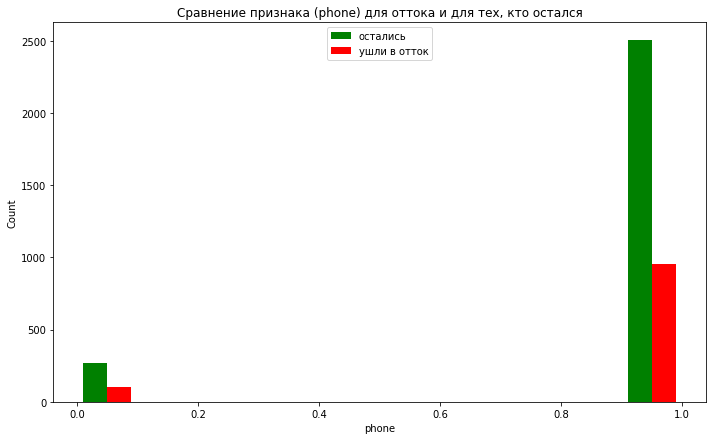

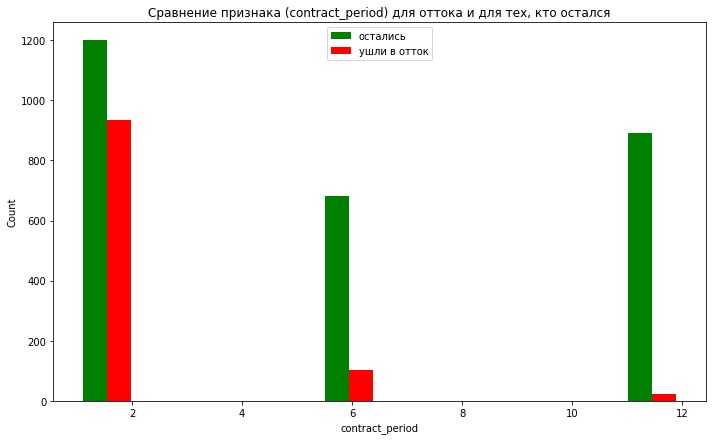

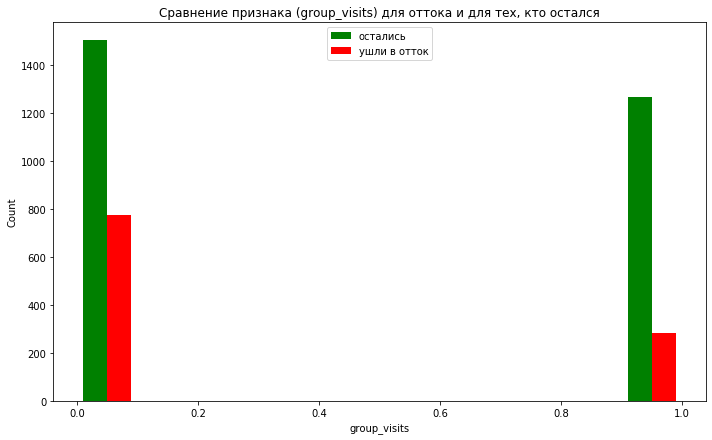

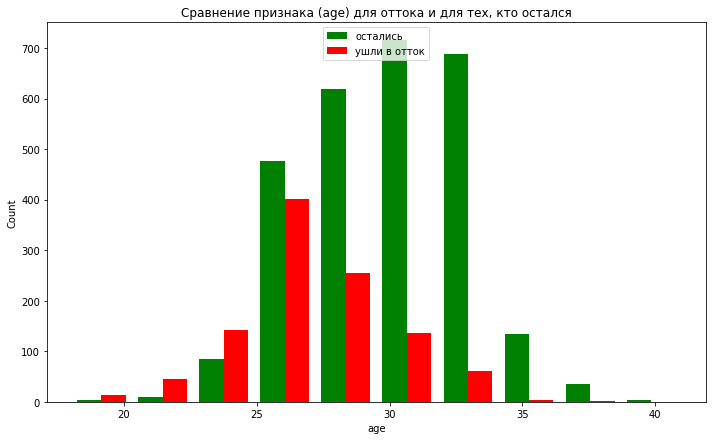

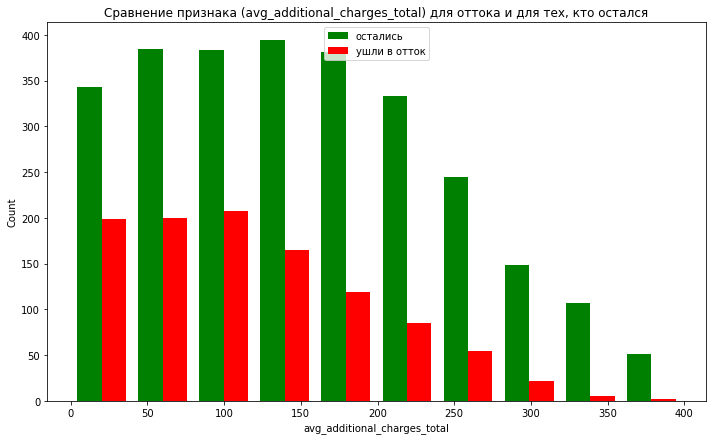

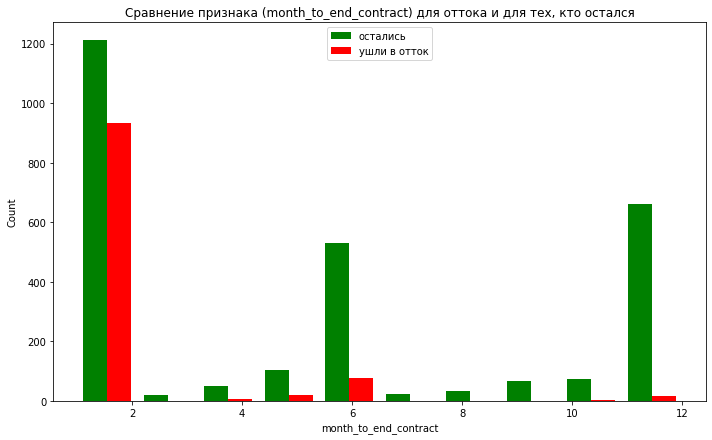

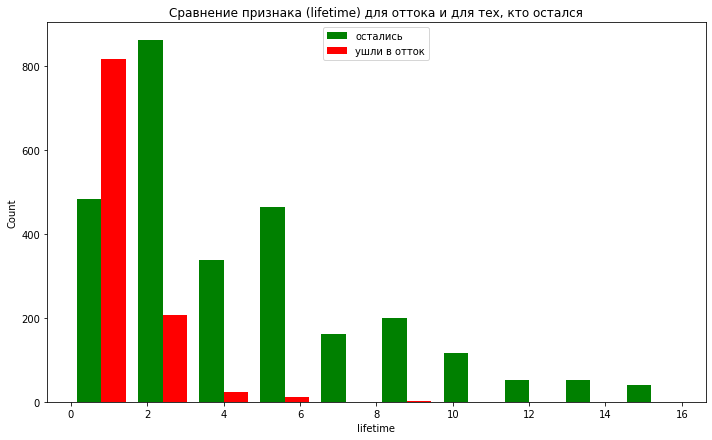

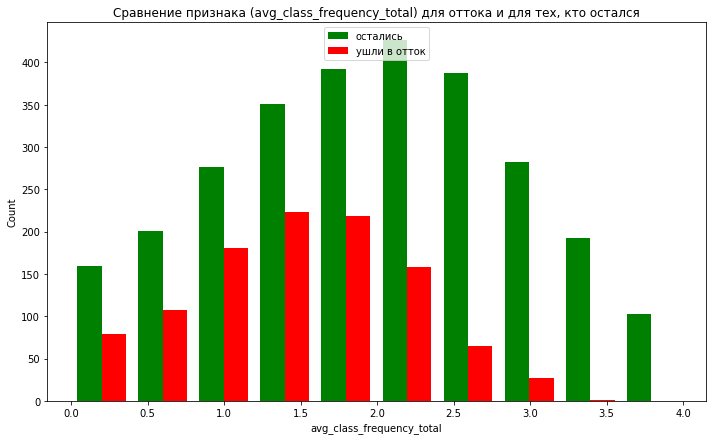

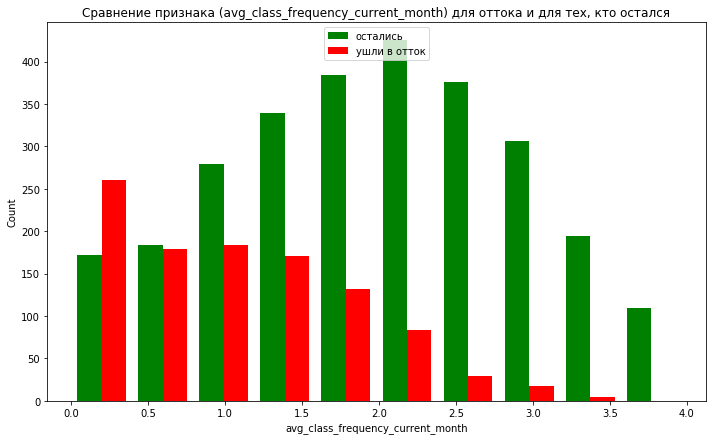

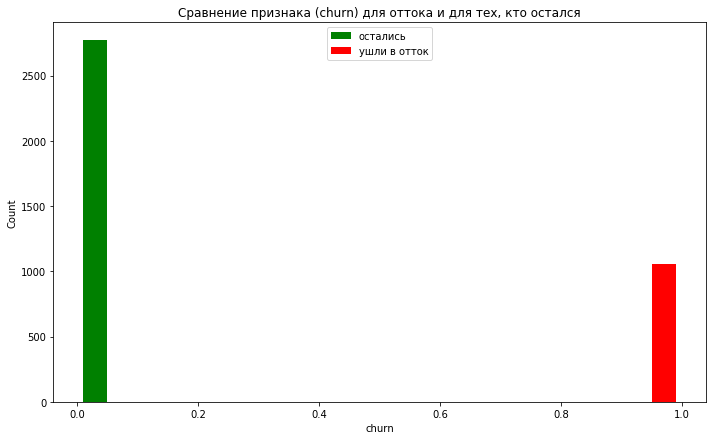

In [20]:
for col in data.columns:
    fig, ax1 = plt.subplots(figsize=(10,6))
    colors = ['green','red']
    ax1.hist([data_churn_0[col], data_churn_1[col]], color=colors, label=['остались', 'ушли в отток'])
    plt.legend(loc='upper center')
    ax1.set_ylabel("Count")
    ax1.set_xlabel(col)
    plt.tight_layout()
    title = 'Сравнение признака (' + col + ') для оттока и для тех, кто остался'
    plt.title(title)
    plt.show();

from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))

In [21]:
print('Процент ушедших в отток (относительно всех пользователей): {:.2%}'.format(data_new_1.query('churn == 1')['churn'].count() / len(data_new_1)))
print('Процент оставшихся (относительно всех пользователей): {:.2%}'.format(data_new_1.query('churn == 0')['churn'].count() / len(data_new_1)))

Процент ушедших в отток (относительно всех пользователей): 27.68%
Процент оставшихся (относительно всех пользователей): 72.32%



<li> Среди ушедших в отток одинаковое количество мужчин и женщин.
<li> Среди тех, кто ушед в отток, большая часть с длительностью абонемента 1 месяц и очень небольшая доля ушла с абонементом в 12 месяцев
<li>  В среднем ушедшие в отток - моложе тех, кто остался.
<li> Суммарная выручка ушедших в отток значительно ниже в сравнении с теми, кто остался. Отчасти из-за того, что продолжительность контракта ушедших в отток - 1 месяц, а среди тех кто остался в сумме контрактов на 6 и 12 месяцев значительно больше.
<li> Лайфтайм тех кто остался выше, чем тех, кто ушел в отток.
<li> Пользователи, попавшие в отток, посещаяли фитнес зал реже, чем те, кто остался.
<li> В выборке 72 процента пользовталей остались, а 28 процентов ушли.

### Матрица корреляций.

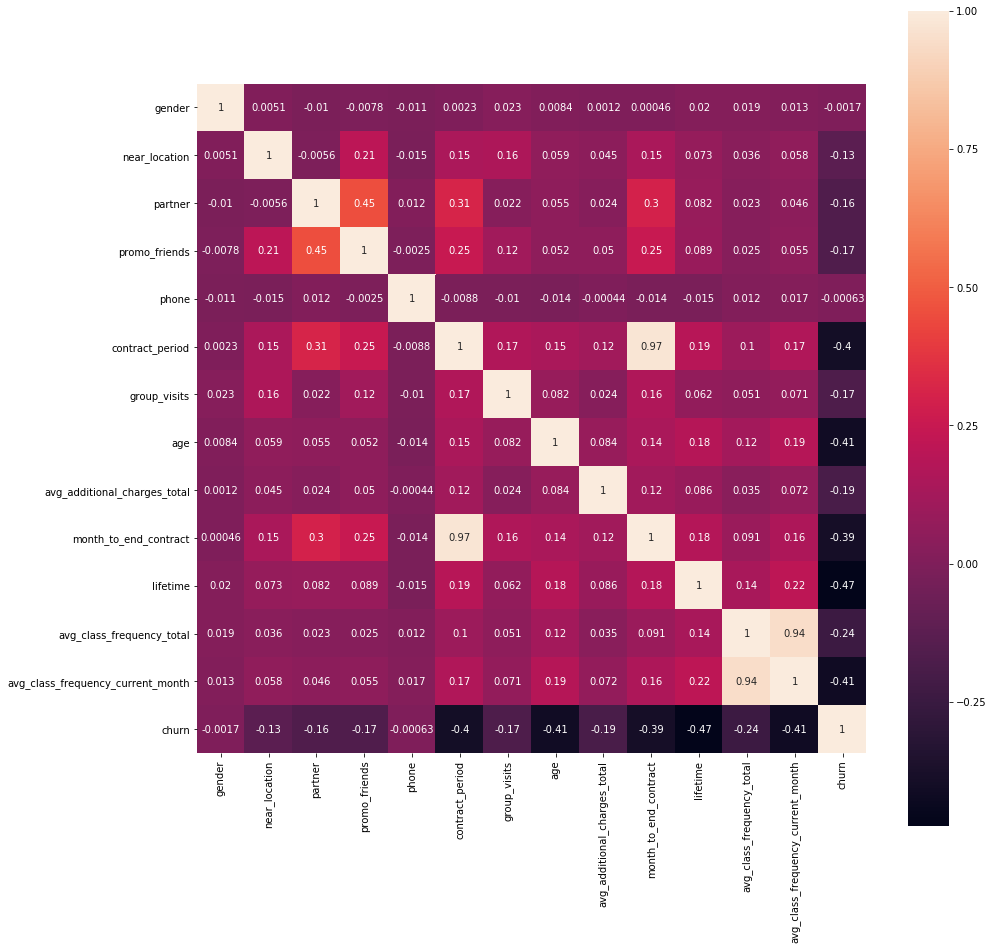

In [22]:
cm = data_new_1.corr() #вычисляем матрицу корреляций
#print(cm)
fig, ax = plt.subplots(figsize=(15, 15))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot = True, square=True) 
plt.show()



На матрице корреляции видно, что есть сильно коррелирующие признаки:
    
    1. Это зависимость avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента) и avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц). По сути это одинаковые показатели. Думаю, что необходимо удалить признак avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента)
    
    2. Month_to_end_contract (срок до окончания текущего действующего абонемента (в месяцах) и Contract_period (длительность текущего действующего абонемента) Несмотря на то, что корреляция очень высокая, в данном случае нет необходимости удалять этот признак. Если бы в данных была отметка о том, что все пользователи купили аобонементы в какой-то определенный месяц, тогда это были бы взаимозависимые признаки и один из них необходимо было бы удалить. Но таких данных нет.
    


In [23]:
data_new_1 = data_new_1.drop(['avg_class_frequency_total'], axis = 1)

## Модель прогнозирования оттока клиентов
Целевой признак — факт оттока клиента в следующем месяце: data['churn']

In [24]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data_new_1.drop(['churn'], axis = 1)
y = data_new_1['churn']

In [25]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [26]:
scaler = StandardScaler()
# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train) 
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### Обучение модели. Метод логистическая регрессия.

In [27]:
#логистическая регрессия
lg_model = LogisticRegression(solver='liblinear', random_state=0)
lg_model.fit(X_train_st, y_train)
lg_y_pred = lg_model.predict(X_test_st)
lg_y_probas = lg_model.predict_proba(X_test_st) 

In [28]:
print('Массив вероятностей для тестовой выборки:', 
      '1 значение - вероятность принадлежности к классу 0 («событие не наступит»),', 
      'второе значение - вероятность принадлежности к классу 1 («событие наступит»). ')
print(lg_y_probas[:10].round(2))

Массив вероятностей для тестовой выборки: 1 значение - вероятность принадлежности к классу 0 («событие не наступит»), второе значение - вероятность принадлежности к классу 1 («событие наступит»). 
[[0.94 0.06]
 [0.98 0.02]
 [0.97 0.03]
 [0.7  0.3 ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.44 0.56]
 [0.28 0.72]]


In [29]:
 print('LogisticRegression Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
            accuracy_score(y_test, lg_y_pred),
            precision_score(y_test, lg_y_pred),
           recall_score(y_test, lg_y_pred),
        ))

LogisticRegression Accuracy:0.90 Precision:0.79 Recall:0.85


### Обучение модели. Метод случайный лес.

In [30]:
#случайный лес
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_y_pred = rf_model.predict(X_test_st)
rf_y_probas = rf_model.predict_proba(X_test_st) 

In [31]:
print('Массив вероятностей для тестовой выборки:', 
      '1 значение - вероятность принадлежности к классу 0 («событие не наступит»),', 
      'второе значение - вероятность принадлежности к классу 1 («событие наступит»). ')
print(rf_y_probas[:10].round(2))

Массив вероятностей для тестовой выборки: 1 значение - вероятность принадлежности к классу 0 («событие не наступит»), второе значение - вероятность принадлежности к классу 1 («событие наступит»). 
[[0.96 0.04]
 [0.89 0.11]
 [0.99 0.01]
 [0.76 0.24]
 [1.   0.  ]
 [0.72 0.28]
 [0.99 0.01]
 [0.99 0.01]
 [0.65 0.35]
 [0.24 0.76]]


In [32]:
print('RandomForestClassifier Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
            accuracy_score(y_test, rf_y_pred),
            precision_score(y_test, rf_y_pred),
           recall_score(y_test, rf_y_pred),
        ))

RandomForestClassifier Accuracy:0.90 Precision:0.80 Recall:0.81



    Т.к. в исходных данных не соблюдено условие баланса классов (когда объектов каждого класса примерно поровну), то метрика accuracy не является показательной. Необходим обратить внимание на две другие метрики.
    В данном случае лучше, если пользователь попадет в группу оттока (хотя таковым не является), чем не попадет (и менеджеры пропустят этого клиента). Поэтому оценивать модель необходимо по метрике recall. Этот показатель выше у модели ленейной регрессии.

## Кластеризация клиентов

### Матрица расстояний и дендрограмма на стандартизованной матрице признаков

In [33]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(data_new_1.drop(columns = ['churn'])) # обучаем нормализатор и преобразуем набор данных 

In [34]:
linked = linkage(x_sc, method = 'ward')

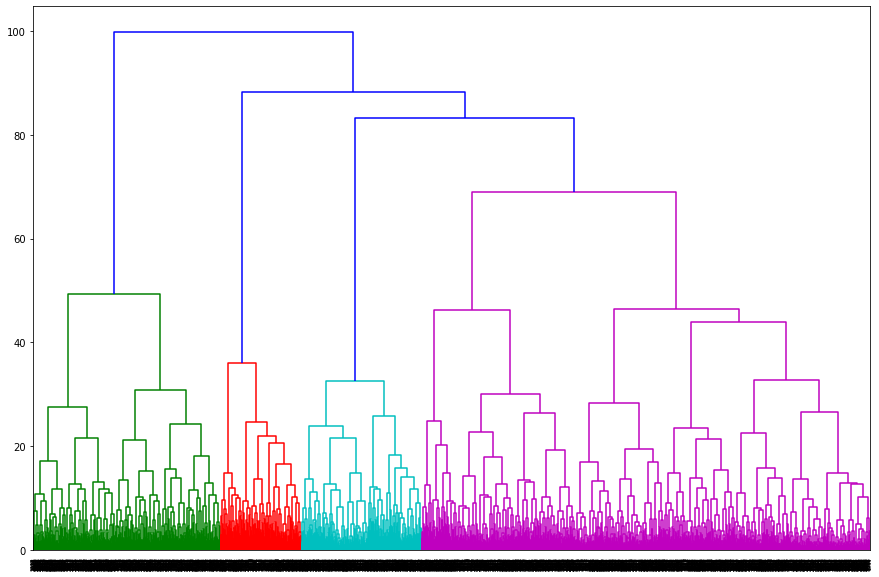

In [35]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 


На основании дендограммы можно сделать вывод о том, что данные необходимо разбить на 5 кластеров.

### Модель кластеризации на основании алгоритма K-Means.

In [36]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)

In [37]:
print(x_sc[:5])

[[ 0.97677102  0.43142292  1.02485179  1.49492384 -3.05343252  0.29717188
   1.21217763 -0.04676831 -1.41097564  0.1677892  -0.15467125 -1.72201002]
 [-1.02378139  0.43142292 -0.97575084 -0.6689304   0.32750028  1.61653233
   1.21217763  0.56561677 -0.32751079  1.83634575  1.06173716  0.20016644]
 [-1.02378139  0.43142292  1.02485179 -0.6689304   0.32750028 -0.80229517
  -0.82496161 -0.35296085 -0.14967406 -0.78567168 -0.45877336  0.02533948]
 [-1.02378139  0.43142292  1.02485179  1.49492384  0.32750028  1.61653233
   1.21217763  1.17800185 -0.88068636  1.83634575 -0.45877336  1.65617639]
 [ 0.97677102  0.43142292  1.02485179  1.49492384  0.32750028 -0.80229517
  -0.82496161 -0.96534593  0.60471151 -0.78567168 -0.15467125 -0.59493499]]


In [38]:
labels = km.fit_predict(x_sc)
data_new_1['cluster'] = labels

### Средние значения признаков для кластеров.

In [39]:
display(data_new_1.groupby('cluster').agg('mean'))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,
0,0.528302,0.859838,0.469003,0.312668,0.0,4.770889,0.420485,29.293801,143.244510,4.471698,3.654987,1.659802,0.277628
1,0.503018,0.000000,0.464789,0.076459,1.0,2.187123,0.209256,28.539235,132.572389,2.062374,2.635815,1.517696,0.450704
2,0.488525,0.989071,0.937705,1.000000,1.0,7.121311,0.502732,29.462295,149.330881,6.515847,4.107104,1.816963,0.138798
3,0.522743,1.000000,0.190343,0.075577,1.0,1.545836,0.360392,28.715185,135.768044,1.489153,2.976207,1.563934,0.410777
4,0.517799,0.932039,0.538835,0.011327,1.0,10.067961,0.511327,30.114887,159.340189,9.190939,4.467638,2.082346,0.030744



В каждом кластере практически поровну мужчин и женщин, а так же средний возраст не сильно зависит от кластера. Для каждого кластера можно выделить некоторые особенности.
    
    Нулевой кластер: это кластер, где практически всепользователи находятся рядом с фитнес-центром, но не указали номер телефона для связи. Отток 27,7 %
    
    Первый кластер: это кластер, в котором пользователи находятся далеко от локации от фитнес-центра. Отток 45%
    
    Второй кластер: это кластер, пользователи в котором пришли по промоации "Приведи друга" и по партнерской программе, а так же рядом с локацией. Отток 14 %
    
    Третий кластер: это кластер, пользователи находятся рядом с фитнесом, но не пришли по промоации "Приведи друга" и по партнерской программе. Период контракта 1 - 2 месяца. Отток 41 %
    
    Четвертый кластер: это пользователи, которые находятся рядом с фитнес-центром, но период контракта 6 - 12 месяцев. Отток 3%
    
    

### Распределения признаков для кластеров

In [40]:
cl_0 = data_new_1.query('cluster == 0')
cl_1 = data_new_1.query('cluster == 1')
cl_2 = data_new_1.query('cluster == 2')
cl_3 = data_new_1.query('cluster == 3')
cl_4 = data_new_1.query('cluster == 4')

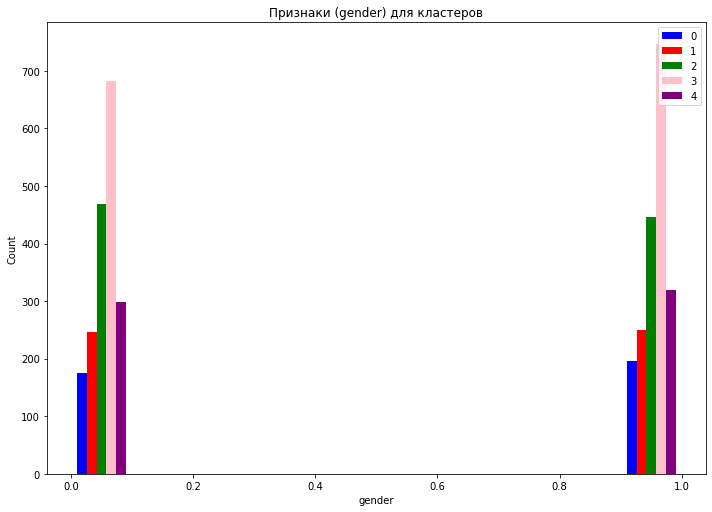

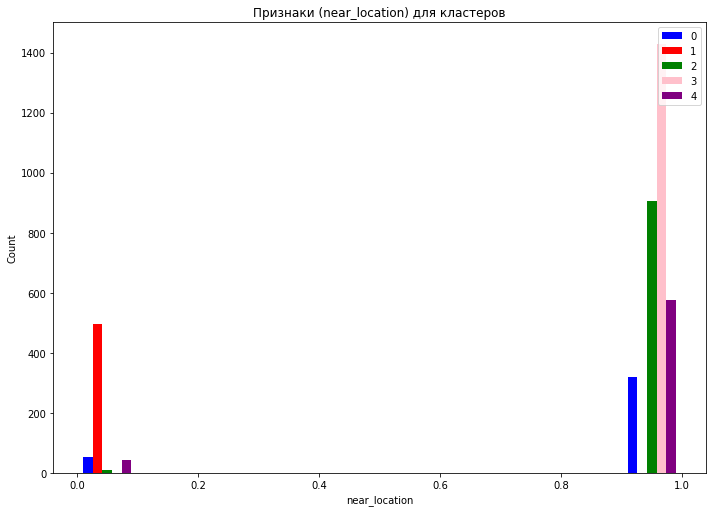

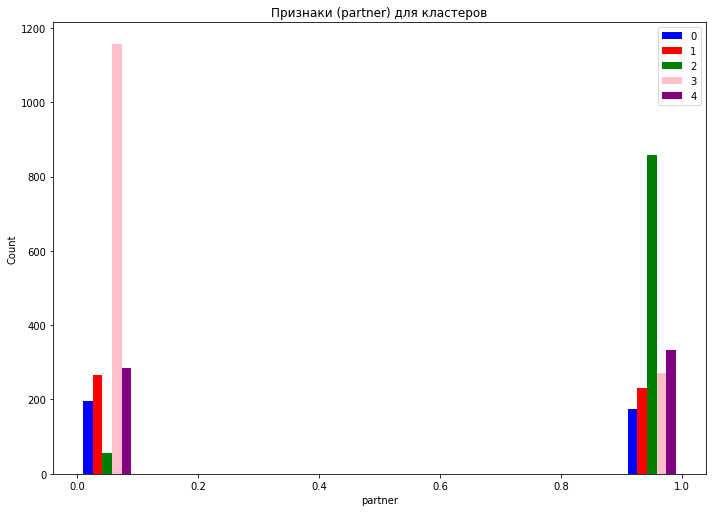

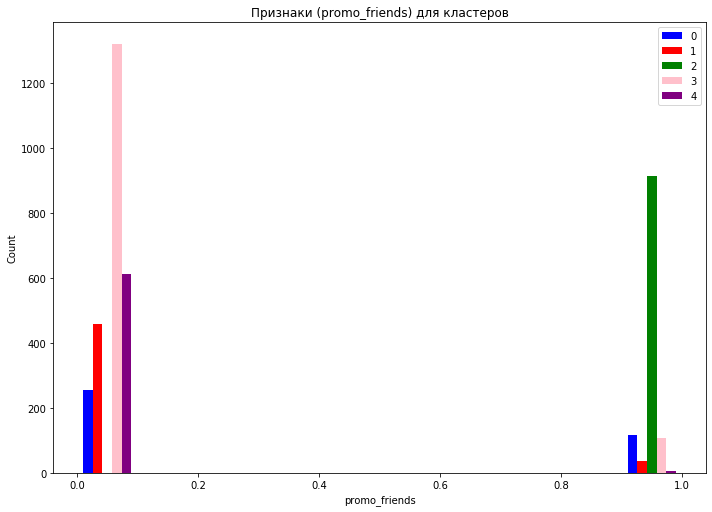

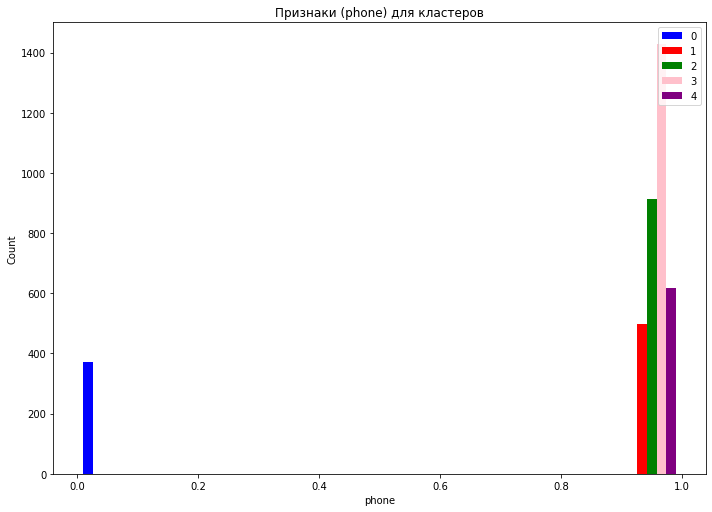

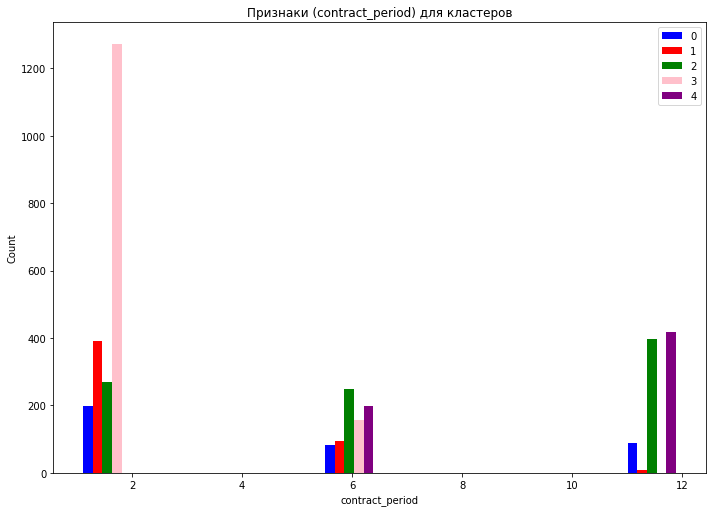

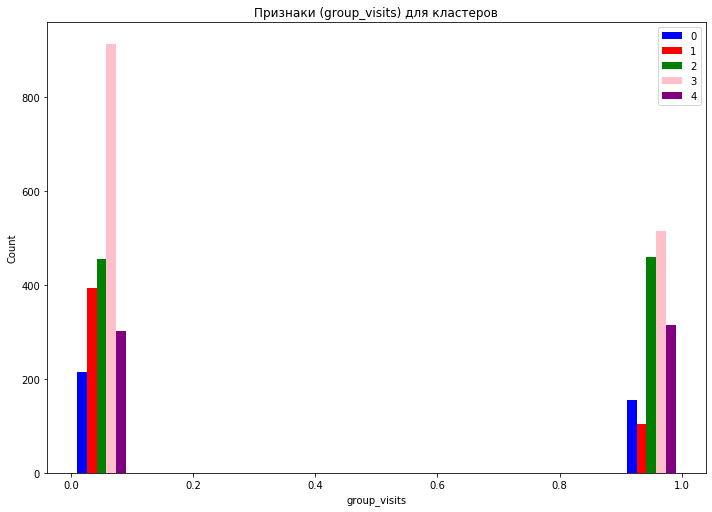

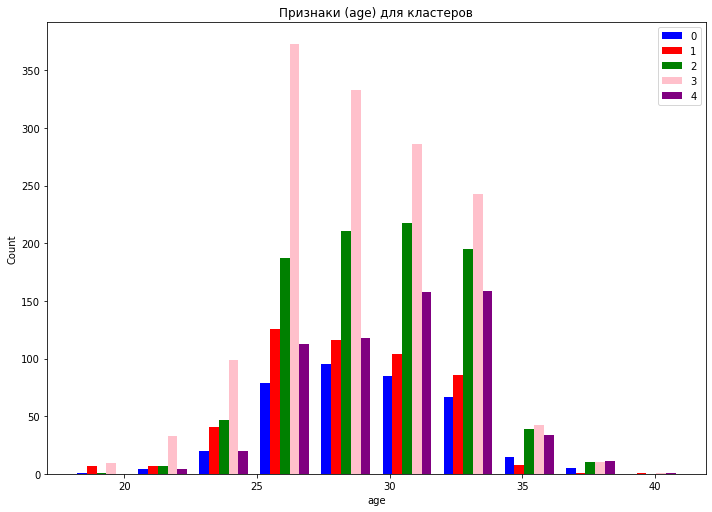

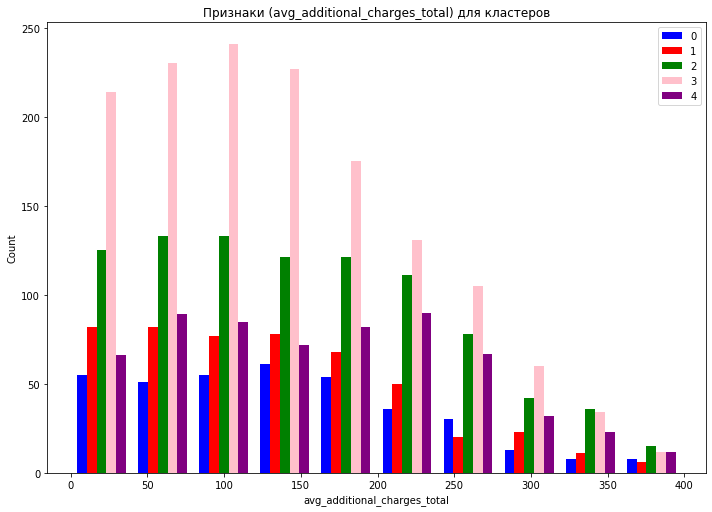

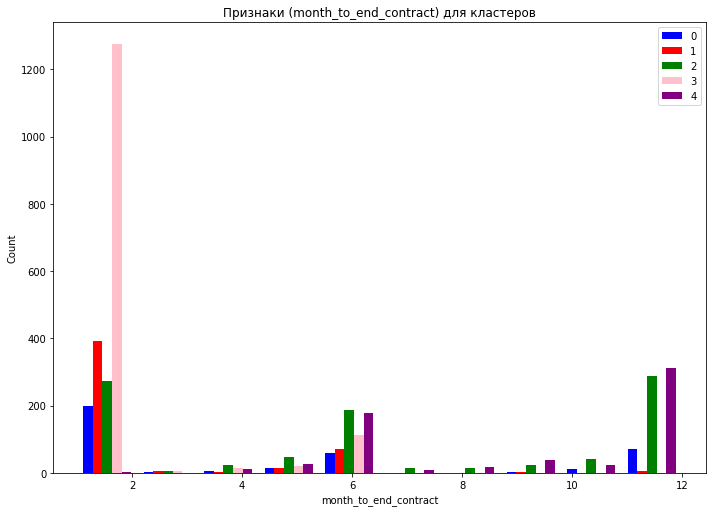

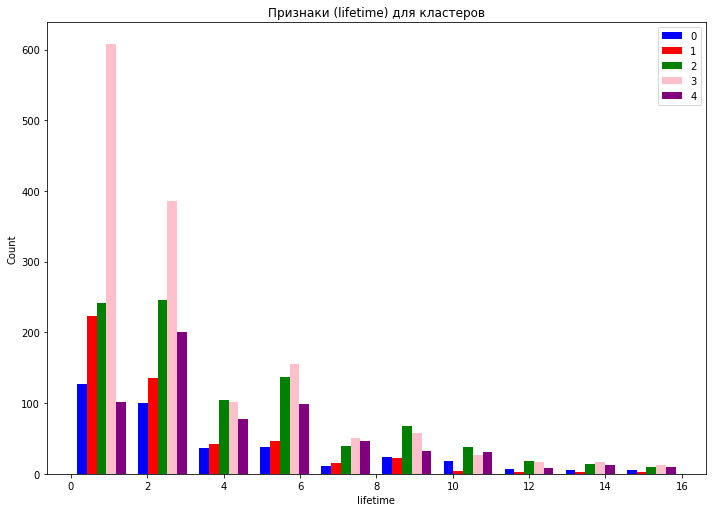

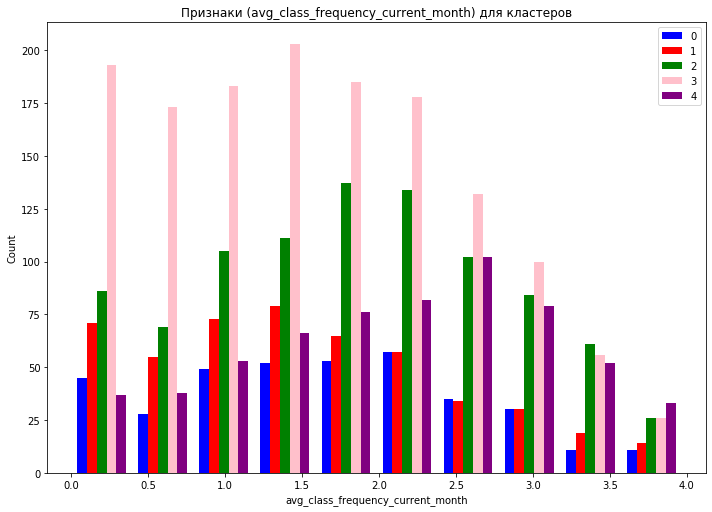

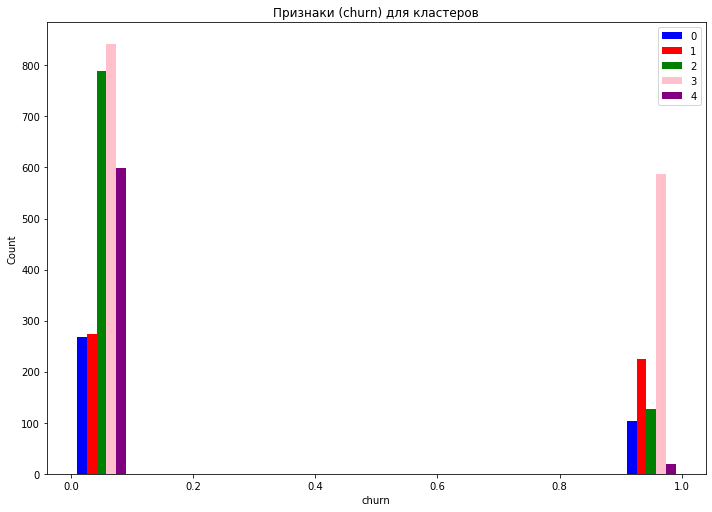

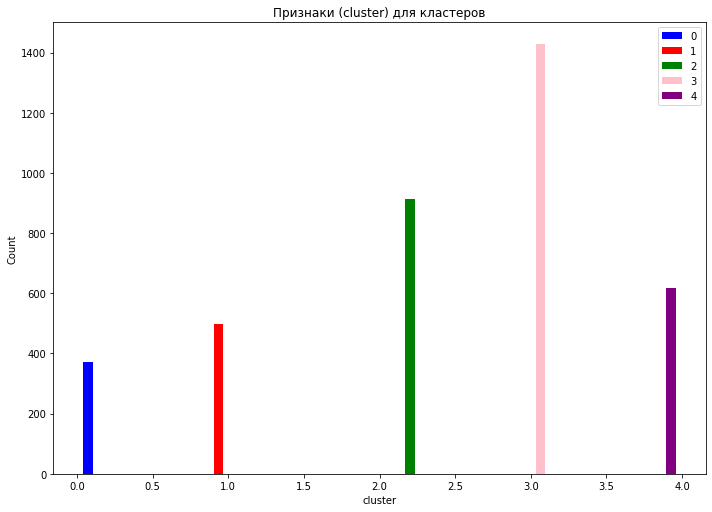

In [41]:
for col in data_new_1.columns:        
    fig, ax2 = plt.subplots(figsize=(10,7))
    colors = ['blue','red', 'green', 'pink', 'purple']
    ax2.hist([cl_0[col], cl_1[col], cl_2[col], cl_3[col], cl_4[col]], color=colors, label=['0', '1', '2', '3', '4'])
    plt.legend(loc='upper right')
    ax2.set_ylabel("Count")
    ax2.set_xlabel(col)
    plt.tight_layout()
    title = 'Признаки (' + col + ') для кластеров'
    plt.title(title)
    plt.show();
    
from IPython.display import display, HTML
js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
display(HTML(js))


    Графики подтвердили выводы, сделанные ранее.

### Доля оттока для каждого кластера.

In [42]:
claster_churn = data_new_1.groupby('cluster')['churn'].agg(['sum', 'count']).reset_index()
claster_churn['churn_%'] = (claster_churn['sum'] / claster_churn['count'] *100).round(2)

In [43]:
display(claster_churn)

,cluster,sum,count,churn_%
0,0,103,371,27.76
1,1,224,497,45.07
2,2,127,915,13.88
3,3,587,1429,41.08
4,4,19,618,3.07



Кластер номер 4 показал наибольшую долю оттока. Можно сделать вывод, что такие показатели как месторасположение очень сильно влияют на отток: если пользователь не живет (или не работает) рядом с финес-центром, то с вероятностью 45 процентов он уйдет в отток. Так же плохой показатель у 1 кластера: чем меньше срок контракта, тем выше вероятность, что пользователь попадет в отток. Кластер 0, наоборот, показал очень низкий процент оттока.

## Общий вывод

**Средний посетитель фитнес клуба:** Портрет среднего пользователя фитнес-центра: пол не имеет значения, посетитель живет/работает рядом с фитнес-клубом, длительность абонемента от 1 месяц или 6 месяцев, возраст: 29 лет, посещает клуб 1 - 2 раза в неделю.

**На основании данных об оттоке, можно сделать следующие выводы:**
<li> Пол не влияет на отток: в обеих группах примерно одинаковое кол-во мужчин и женщин.
<li> В группе, которая ушла в отток, длительность контракта в среднем 2 месяца, а у тех, кто остался - 6 месяцев. 
<li> Средний возраст клиентов в обеих группах 29 - 30 лет
<li> Ушедшие в отток в среднем посещали фитнес-клуб реже (1 раз в неделю)
<li> Пользователи, попавшие в отток, посещали фитнес-зал реже, чем те, кто остался.
<li> Месторасположение очень сильно влияют на отток: если пользователь не живет (или не работает) рядом с фитнес-центром, то с большой вероятностью он уйдет в отток. 
<li> Чем меньше срок контракта, тем выше вероятность, что пользователь попадет в отток.

## Рекомендации

На основании проведенного исследования, могу предложить следующие стратегии взаимодействия с клиентами:
1. ***Большой отток наблюдается среди пользователей, которым необходимо добираться до фитнес-центра:*** таким пользователям можно предложить скидку при покупке абонемента в более удобный по месторасположению фитнес-центр сети

2.  ***Большой отток наблюдается среди пользователей, длительность контракта у которых составляет 1 месяц:*** таким пользователям можно предложить скидку  на продление абонемента.

3. ***Продумать систему мотивации за посещения клуба,*** т.к. если пользователь редко ходит, то вероятность попадания в отток увеличивается.

4. ***Доля ушедших в отток клиентов, не указавших мобильный телефон для связи, так же велика.*** Поэтому необходимо продумать мотивацию за оставленный контактный телефон (напрмер, гарантией скидки на абонемент)